# Support Vector Machines
[![Run in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bobmh43/handson_ml/blob/master/notebooks/ch5_SVM.ipynb)


# Exercise questions
1. What is the fundamental idea behind SVMs?
A support vector classifier performs binary classification by separating the feature space with a decision boundary and a margin on both sides of it. The training process seeks to maximize the margin size (lowers the generalization error) while preventing margin violations (hard margin) or reducing margin violations to a certain degree determined by C (soft margin).

2. What is a support vector?
A support vector is an instance that lies on or in the margin. Only the support vector affect the decision function that results from training.

3. Why is it important to scale the features before feeding it to a SVM?
SVMs are sensitive to feature scales and would ignore the features with the smallest scales.

4. Can an SVC output a confidence score when classifying an instance? How about a probability?
The confidence score is the decision function's value. It has no probabilistic meaning.

5. Should you use the primal or dual form of the SVM problem to train a model on a dataset with millions of instances and hundreds of features?
First, we assume we are dealing with a linear SVM, as a kernelized SVM must work with the dual problem. For a linear SVM, solving the primal problem is O(m), where m is the number of training instances, while solving the dual problem is O(m^2) or O(m^3). Thus, we should use the primal form.

6. Suppose you trained a SVC with a Gaussian RBF kernel, and it is underfitting the training set. How should you modify the gamma and C hyperparameters?
A larger gamma means the Gaussian bell curve has a smaller variance, each training instance has a smaller sphere of influence, and the decision boundary curve hugs the training instances more closely, and the model becomes more complex and less regularized. Thus, we should increase the gamma.
A larger C means the model emphasizes correctly classification of training instances more strongly, and the margin is narrower and has fewer violations.

# My review questions:
1. How do we remember the computational complexities of the primal and dual forms of the SVM problem?
Primal -> finding weights (n of them ) -> scales poorly with n
Dual -> finding alphas (m of them) -> scales poorly with m -> prefers complex but small datasets

2. How about for the normal equation and the GD for linear regression?
Normal equation -> XtX inv -> relies on n -> slow for large number of features.
Gradient descent -> existence of minibatch G -> slow for large batch -> slow for large number of instances.

3. Why would we want to create new features from the existing ones? What is a problem when we do so? How does the kernel trick solve this issue for SVMs?
If the training dataset is not linearly separable, introducing polynomial features or similarity features (exp(-gamma(||a-b||^2))) lifts the feature space into higher dimensions and likely helps the classes be linearly separable. The downside is that the data would now contain too many features for the model to train quickly.
The kernel trick simulates this lifting into higher dimensions (through the transform \phi)without the added computational complexity. The dual problem of the SVM involves the training instances only as dot products of each other, so we can replace $\phi(a) \cdot \phi(b)$ with $K(a, b)$, where K is the kernel function. Common kernels include the polynomial kernel and the Gaussian RBF kernel.

## What hyperparameters mean: (ito regularization and learning from instances.)
Soft margin: C (inverse reg param): smaller C -> less emphasis on correct classification -> learn from data less -> more regularization.
Polynomial kernel:
    - degree
    - coef0 or r: high r means more influence from lower-degree terms -> less influence from higher degree terms -> more regularization
Gaussian RBF kernel: gamma (inverse reg param): smaller gamma -> bigger bell-curve variance -> instances have large sphere of influence -> decision boundary hugs instances more loosely -> more regularized.

## Which sklearn class to use:
- <10k samples: SVC (SMO), maybe with nonlinear `kernel`
- 10k-100k samples: LinearSVC (coordinate descent). Also try LinearSVC if there are a large number of features.
- >100k samples: SGDClassifier (SGD). But need to tune learning rate. Can do online/out-of-core.
- Added a kernel approximation if needed.

The same deal applies to LinearSVR, SVR and SGDRegressor with epsilon_insensitive loss. Just note that the model is now a regressor and the loss is now epsilon-insensitive instead of hinge.

The Ridge, Lasso and ElasticNet algorithms are deterministic and fast converging. SGDRegressor with MSE and penalties is stochastic and converges fast but only to an approximate solution. However, SGDRegressor scales well with m and can perform online/out-of-core learning. It is used when training samples >>100k.

## Notes:
- For both the primal problem and the dual problem, only the support vectors influence the decision function. For the primal problem, the weights are a linear combination of the support vectors. On the other hand, it is easy to see in the dual problem, as the only KKT multipliers that are not 0 are the ones associated with the support vectors.
- GridSearchCV with C and gamma spaced exponentially apart to search for good values.
- USE: sklearn.inspection.DecisionBoundaryDisplay
- Multiclass classification with SVC uses OVO. We need to break ties when we have a region where three classes each beat another (eg. rock beats scissors, scissors beats paper, and paper beats rock).

## Probability Calibration for classifiers.
Not all classifiers output probabilities and not all probabilities are calibrated, as in P(y=1 | predict_proba) != predict_proba. We can see this with a calibration curve, which plots P(y=1 | predict_proba) vs predict_proba, after binning the instances by the predict_proba and finding the proportion of y=1 in each bin. We will see that logistic regression is well-calibrated because of its canonical link function, that naive bayes is overconfident, and that random forests and svms are underconfident (sigmoid shaped calibration curve).

How do we fix this issue? One way is Platt's logistic model: after the classifier is trained on the training data, a logistic regressor is trained on the validation data, trying to predict the conditional event probability P(y=1 | f) given the output of the classifier f. However, Platt's method is most effective only for symmetric and slight underconfidence (mostly SVMs). Another method is isotonic regression, which is more general but needs >1000 samples to prevent overfitting.

In [ ]:
import numpy as np
from scipy.stats import loguniform, uniform
import pandas as pd
from pandas.plotting import scatter_matrix
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.linear_model import SGDClassifier
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Exercise compare SVM classifiers

In [ ]:
import numpy as np
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

def compare_classifiers():
    '''
    Exercise 9: Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.
    '''
    # data: iris. Setosa and Versicolor are linearly separable.
    X, y = sklearn.datasets.load_iris(return_X_y=True)

    # features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
    # we only want index 2 and 3
    X = X[:, 2:]

    # target names: setosa, versiclor, virginica
    # we only want 0 and 1 (no 2)
    instances_mask = np.logical_or(y == 0, y == 1)
    y = y[instances_mask]
    X = X[instances_mask]
    ## better written:
    # setosa_or_versicolor = y == 0 | y == 1
    # y = y[setosa_or_versicolor]
    # X = X[setosa_or_versicolor]

    # remember to standard scale!
    # we don't need to make a pipeline as we won't be predicting, only accessing fitted coefficients
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # models:
    C = 5
    alpha = 0.05
    clf_list = [
        LinearSVC(loss="hinge", C=C, random_state=42),
        SVC(C=C, kernel="linear", random_state=42),
        SGDClassifier(loss="hinge", alpha=alpha, random_state=42)
    ]

    endpts_list = []
    for estimator in clf_list:
        estimator.fit(X_scaled, y)
        # get decision boundary
        m = -estimator.coef_[0, 0] / estimator.coef_[0, 1]
        b = -estimator.intercept_[0] / estimator.coef_[0, 1]
        endpts_list.append(scaler.inverse_transform(
            [[-10, -10 * m + b],
             [10, 10 * m + b]]
        ))

    # Plotting decision boundaries and (training) data.
    # plt.figure(figsize=(11, 4))
    # linetype_list = ["k:", "b--", "r-"]
    # for clf, endpts, line_type in zip(clf_list, endpts_list, linetype_list):
    #     plt.plot(endpts[:, 0], endpts[:, 1], line_type, label=clf.__class__.__name__)
    # plt.plot(X[y==0][:, 0], X[y==0][:, 1], "ys", label="Setosa")
    # plt.plot(X[y==1][:, 0], X[y==1][:, 1], "bo", label="Versicolor")
    # plt.xlabel("Petal length")
    # plt.ylabel("Petal width")
    # plt.legend(loc="upper center")
    # plt.axis([0, 5.5, 0, 2])
    # plt.grid()
    # plt.show()

    # can try using DecisionBoundaryDisplay
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for estimator, ax in zip(clf_list, axes):
        disp = DecisionBoundaryDisplay.from_estimator(
            estimator,
            X_scaled,
            response_method="predict",
            xlabel="Petal length",
            ylabel="Petal width",
            ax=ax,
            cmap="inferno"
        )
        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=~y, edgecolors="k")
        ax.set_title(estimator.__class__.__name__)
        #disp.plot()
    fig.tight_layout()
    plt.show()

# Exercise Wine:
Train an SVM classifier on the Wine dataset, which you can load using sklearn.datasets.load_wine(). This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?

## Data Acquisition Phase:

In [ ]:
wine = sklearn.datasets.load_wine(as_frame=True)

In [ ]:
dir(wine)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [ ]:
wine.target.shape

(178,)

In [ ]:
wine.data.shape

(178, 13)

In [ ]:
# setting aside the test set
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2, shuffle=True, stratify=wine.target)

## Data Exploration
- all features numeric, no missing values
- there are outliers in: alcohol, ash, magnesium, total_phenols, flavonoids, proanthocyanins, color_intensity, hue
- linearly correlated:
    - alcohol, proline, color intensity;
    - total_phenols, flavonoids, proanthocyanins, od280/od315_of_diluted_wines, hue;
    - malic acid and hue

In [ ]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [ ]:
X_train.isna().any()

,0
alcohol,False
malic_acid,False
ash,False
alcalinity_of_ash,False
magnesium,False
total_phenols,False
flavanoids,False
nonflavanoid_phenols,False
proanthocyanins,False
color_intensity,False


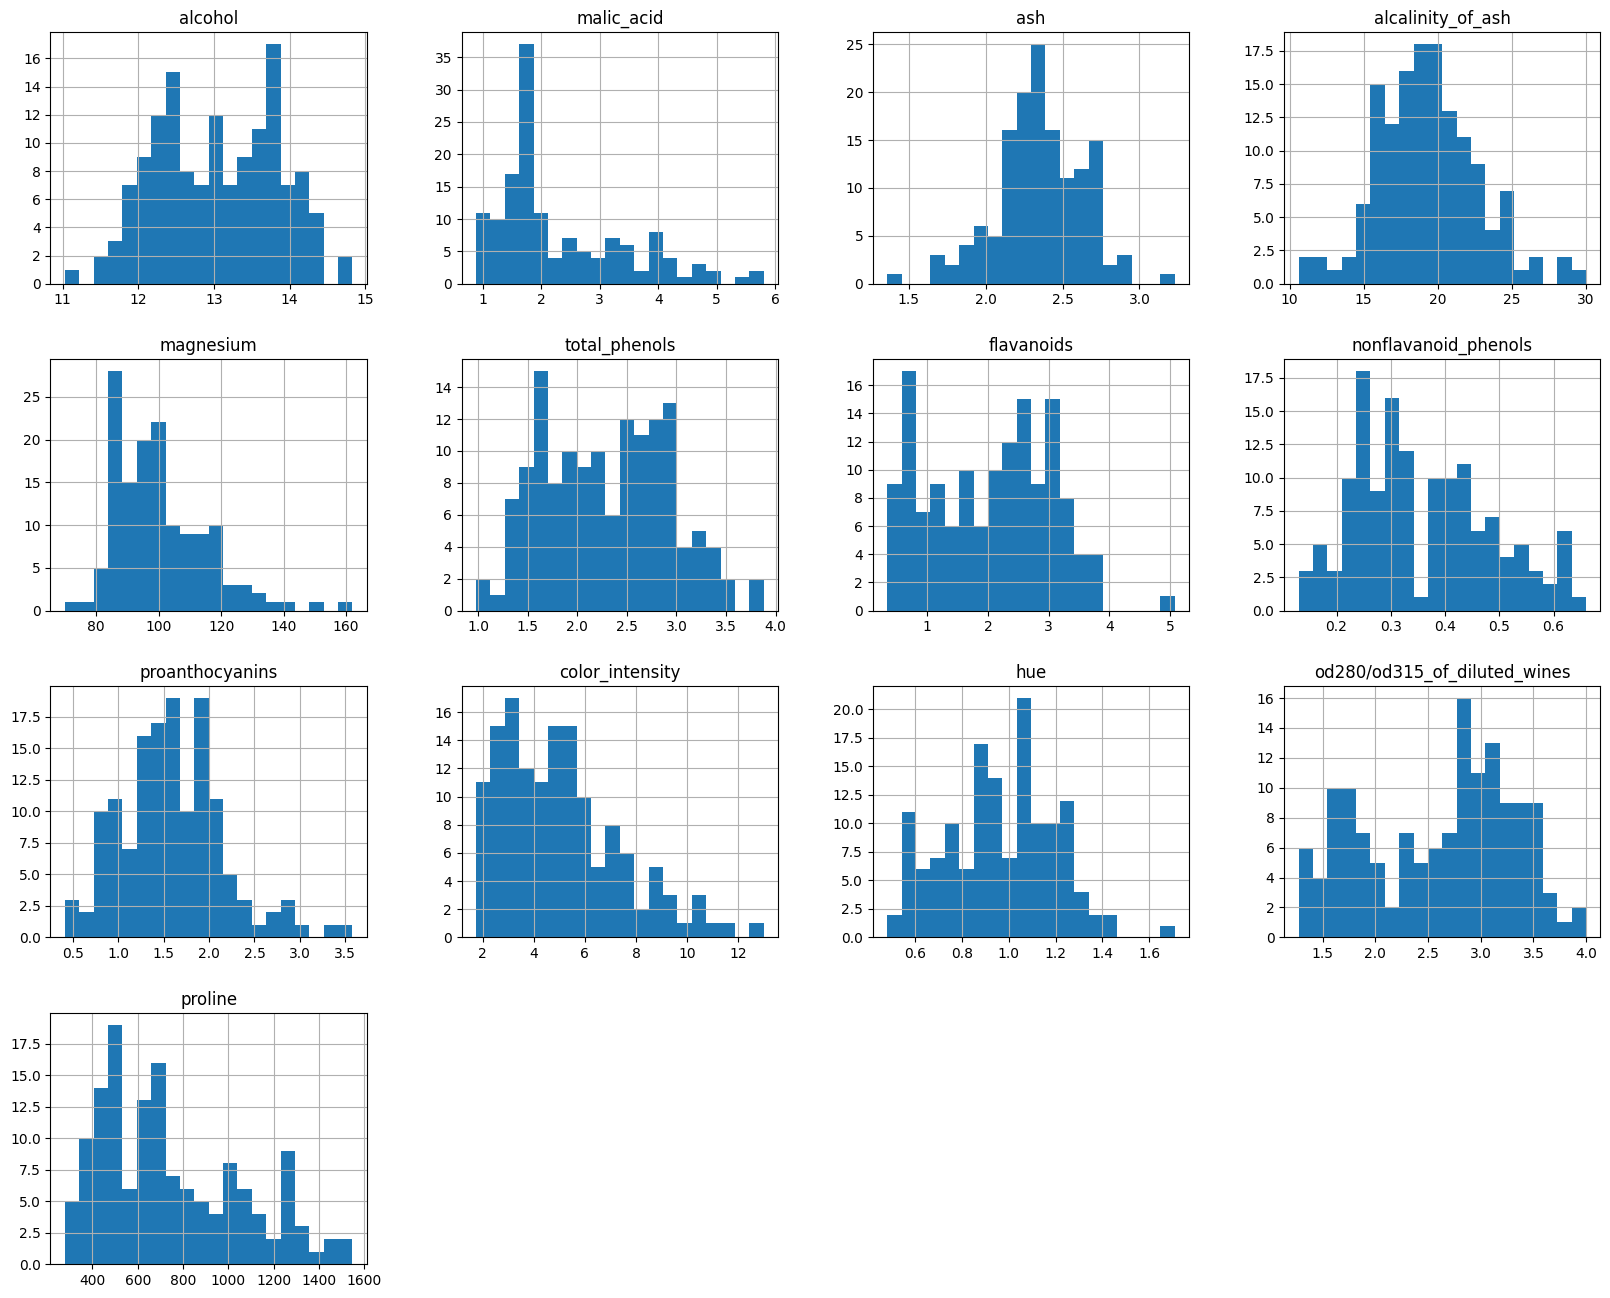

In [ ]:
tmp = X_train.hist(figsize=(20, 16), bins=20)

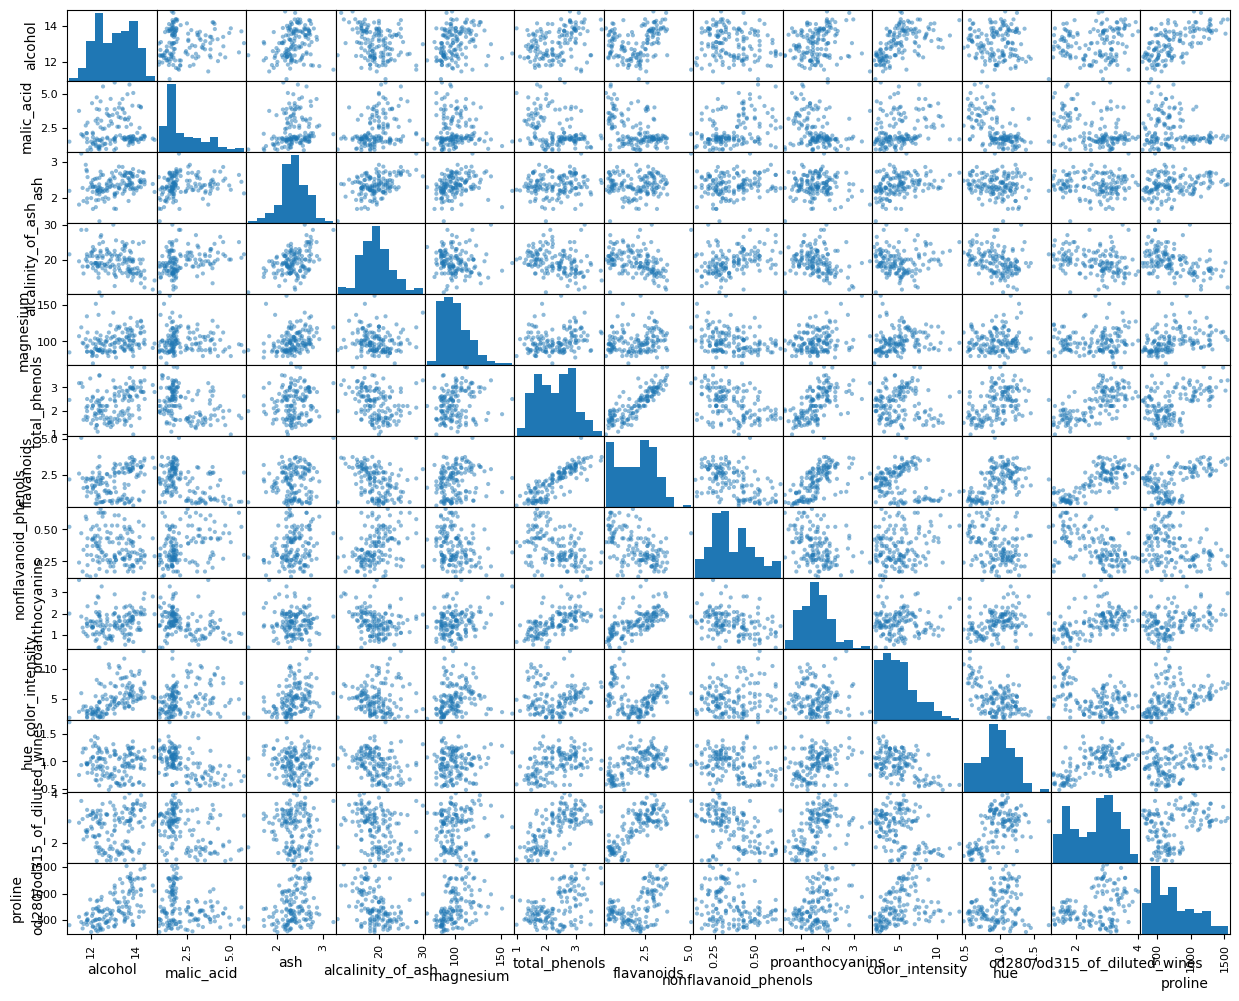

In [ ]:
tmp = scatter_matrix(X_train, figsize=(15,12))

In [ ]:
c = X_train.corr()

In [ ]:
c[abs(c) < 0.5] = "NA"

In [ ]:
c

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.0,NA,NA,NA,NA,NA,NA,NA,NA,0.54312,NA,NA,0.637348
malic_acid,NA,1.0,NA,NA,NA,NA,NA,NA,NA,NA,-0.576411,NA,NA
ash,NA,NA,1.0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
alcalinity_of_ash,NA,NA,NA,1.0,NA,NA,NA,NA,NA,NA,NA,NA,NA
magnesium,NA,NA,NA,NA,1.0,NA,NA,NA,NA,NA,NA,NA,NA
total_phenols,NA,NA,NA,NA,NA,1.0,0.859354,NA,0.606446,NA,NA,0.691986,NA
flavanoids,NA,NA,NA,NA,NA,0.859354,1.0,NA,0.629466,NA,0.550106,0.796041,NA
nonflavanoid_phenols,NA,NA,NA,NA,NA,NA,NA,1.0,NA,NA,NA,NA,NA
proanthocyanins,NA,NA,NA,NA,NA,0.606446,0.629466,NA,1.0,NA,NA,0.504147,NA
color_intensity,0.54312,NA,NA,NA,NA,NA,NA,NA,NA,1.0,-0.54036,NA,NA


## Model training

An important note about `cross_val_score` and `cross_val_predict`. The former uses the average of the CV validation errors to estimate the generalization error of the final model that trains on all the data. The latter generates *out-of-sample* predictions for every instance, which can be used for diagnostics about the procedure (model + CV), but can't be used to estimate the final generalization error.

In [ ]:
pipe = make_pipeline(StandardScaler(),
                     SVC(random_state=42))

In [ ]:
scores = cross_val_score(pipe, X_train, y_train)
confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([0.96551724, 0.93103448, 1.        , 1.        , 1.        ])

In [ ]:
param_distrib = [
    {"svc__C": loguniform(1e-1, 1e2), "svc__kernel": ["linear"]},
    {"svc__C": uniform(1, 10), "svc__kernel": ["rbf"], "svc__gamma": loguniform(1e-3, 1e-1)},
    {"svc__C": loguniform(1e-1, 1e2), "svc__kernel": ["poly"], "svc__degree": np.arange(2, 10), "svc__coef0": loguniform(1e-1, 1e3)}
]
rcv = RandomizedSearchCV(pipe, param_distrib, n_iter=20, random_state=43)

In [ ]:
rcv.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(random_state=42))]),
                   n_iter=20,
                   param_distributions=[{'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7918c1e29a30>,
                                         'svc__kernel': ['linear']},
                                        {'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7918c1e2a990>,
                                         'sv..._distn_infrastructure.rv_continuous_frozen object at 0x7918c1e2a6f0>,
                                         'svc__kernel': ['rbf']},
                                        {'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7918c1e2afc0>,
                                         'svc__coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7918c1e2aed0>,
                                         'svc__degree': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                         'svc__kernel': ['poly']}],
                   random_state=43)

In [ ]:
rcv.best_params_

{'svc__C': np.float64(9.020471186286665),
 'svc__gamma': np.float64(0.0032273216524928163),
 'svc__kernel': 'rbf'}

In [ ]:
rcv.best_score_

np.float64(0.9790640394088671)

In [ ]:
rcv.score(X_test, y_test)

0.9722222222222222

# Exercise Housing: SVR

Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using sklearn.datasets.fetch_california_housing(). The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?

## Data acquisition

In [ ]:
housing = sklearn.datasets.fetch_california_housing()

In [ ]:
dir(housing)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [ ]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
X = housing.data
y = housing.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# for faster hyperparameter search later
X_mini, _, y_mini, _ = train_test_split(X_train, y_train, train_size=2000, random_state=43)

## Modeling training and fine tuning

must remember to scale!

In [ ]:
pipe = make_pipeline(StandardScaler(),
                     LinearSVR(max_iter=10000, random_state=48))

In [ ]:
cross_val_score(pipe, X_mini, y_mini,
                scoring="neg_root_mean_squared_error", cv=KFold(5, shuffle=True, random_state=48))

array([-0.64031244, -0.71666018, -0.69737651, -0.7387098 , -0.81105702])

LinearSVR didn't work out great, so let's try kernelized SVR instead!

In [ ]:
pipe = make_pipeline(StandardScaler(),
                     SVR())

In [ ]:
# focusing on the rbf kernel
param_distrib2 = {"svr__C": uniform(1, 10), "svr__kernel": ["rbf"], "svr__gamma": loguniform(1e-3, 1e-1)}
rcv2 = RandomizedSearchCV(pipe, param_distrib2, n_iter=10, scoring="neg_root_mean_squared_error", random_state=43)
rcv2.fit(X_mini, y_mini)
print("best estimator: ", rcv2.best_estimator_)
res2 = pd.DataFrame(rcv2.cv_results_)
top_ten2 = res2.sort_values(by=["rank_test_score"])[["params", "mean_test_score", "std_test_score", "rank_test_score"]].iloc[:10]
print(top_ten2)

best estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr',
                 SVR(C=np.float64(4.271390558111397),
                     gamma=np.float64(0.052272705892251366)))])
                                              params  mean_test_score  \
2  {'svr__C': 4.271390558111397, 'svr__gamma': 0....        -0.597050   
5  {'svr__C': 4.949500184310058, 'svr__gamma': 0....        -0.601303   
9  {'svr__C': 1.7666269999644726, 'svr__gamma': 0...        -0.606260   
4  {'svr__C': 1.290138244243604, 'svr__gamma': 0....        -0.624211   
3  {'svr__C': 7.660902130980258, 'svr__gamma': 0....        -0.625651   
0  {'svr__C': 2.1505456638977893, 'svr__gamma': 0...        -0.633360   
8  {'svr__C': 5.049894480472597, 'svr__gamma': 0....        -0.666946   
7  {'svr__C': 9.666486408992002, 'svr__gamma': 0....        -0.670753   
1  {'svr__C': 2.333909641859883, 'svr__gamma': 0....        -0.689662   
6  {'svr__C': 3.544211258598793, 'svr__gamma': 0....     

In [ ]:
-cross_val_score(rcv2.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()

np.float64(0.6021026914630581)

## A hopefully more efficient approach: kernel approximations!

In [ ]:
kpipe = make_pipeline(StandardScaler(),
                      Nystroem(random_state=42, n_jobs=2),
                      LinearSVR(random_state=42, max_iter=10000))

In [ ]:
print(kpipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(n_jobs=-1, random_state=42)),
                ('linearsvr', LinearSVR(max_iter=10000, random_state=42))])


In [ ]:
param_distrib = [
    {"linearsvr__C": uniform(1, 10), "nystroem__kernel": ["poly"], "nystroem__coef0": loguniform(1e-1, 1e2), "nystroem__degree": np.arange(2, 11)},
    {"linearsvr__C": uniform(1, 10), "nystroem__kernel": ["rbf"], "nystroem__gamma": loguniform(1e-3, 1e-1)}
]

In [ ]:
rcv = RandomizedSearchCV(kpipe, param_distrib, n_iter=10, scoring="neg_root_mean_squared_error", n_jobs=-1)

In [ ]:
rcv.fit(X_mini, y_mini)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('nystroem',
                                              Nystroem(n_jobs=2,
                                                       random_state=42)),
                                             ('linearsvr',
                                              LinearSVR(max_iter=10000,
                                                        random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'linearsvr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1ca693bf80>,
                                         'nystroem__coef0': <scipy.stats._distn...x7a1ca6938980>,
                                         'nystroem__degree': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                         'nystroem__kernel': ['poly']},
                                        {'linearsvr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1ca693be90>,
                                         'nystroem__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1ca6939040>,
                                         'nystroem__kernel': ['rbf']}],
                   scoring='neg_root_mean_squared_error')

In [ ]:
pd.DataFrame(rcv.cv_results_).sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_nystroem__gamma,param_nystroem__kernel,param_nystroem__coef0,param_nystroem__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.150924,0.006378,0.018168,0.006677,5.465924,0.045762,rbf,NaN,NaN,"{'linearsvr__C': 5.465924022783304, 'nystroem_...",-0.566245,-0.608650,-0.608287,-0.638039,-0.610490,-0.606342,0.022973,1
4,0.211811,0.055513,0.020228,0.004458,7.413289,0.013609,rbf,NaN,NaN,"{'linearsvr__C': 7.413289352424767, 'nystroem_...",-0.579141,-0.621732,-0.636138,-0.640676,-0.635838,-0.622705,0.022692,2
2,0.090024,0.008973,0.015052,0.000161,3.168104,0.017908,rbf,NaN,NaN,"{'linearsvr__C': 3.1681042874628984, 'nystroem...",-0.581357,-0.626255,-0.639890,-0.644960,-0.637043,-0.625901,0.023097,3
0,0.071070,0.002902,0.014469,0.000695,2.960763,0.004778,rbf,NaN,NaN,"{'linearsvr__C': 2.9607628619360895, 'nystroem...",-0.626817,-0.685195,-0.692608,-0.688973,-0.676180,-0.673955,0.024194,4
8,1.396510,0.079931,0.018150,0.002781,2.024474,NaN,poly,0.112182,2.0,"{'linearsvr__C': 2.024474100688532, 'nystroem_...",-0.619236,-1.181343,-0.733558,-0.676106,-0.697669,-0.781582,0.203292,5
5,2.994045,0.139449,0.015539,0.000646,2.367482,NaN,poly,20.414928,10.0,"{'linearsvr__C': 2.3674821514674216, 'nystroem...",-2.226744,-2.441214,-2.491818,-2.427797,-2.382012,-2.393917,0.090618,6
1,5.523879,0.363666,0.015203,0.000507,8.902519,NaN,poly,24.781583,8.0,"{'linearsvr__C': 8.902518547721069, 'nystroem_...",-1.207382,-34.144725,-4.726674,-0.868676,-1.316359,-8.452763,12.922096,7
9,3.235644,0.354152,0.015038,0.000489,6.476007,NaN,poly,0.362282,6.0,"{'linearsvr__C': 6.476007157830446, 'nystroem_...",-0.743467,-13.888735,-21.986099,-1.328864,-14.883071,-10.566047,8.269258,8
6,6.118237,0.394925,0.015319,0.000514,1.010955,NaN,poly,9.226079,7.0,"{'linearsvr__C': 1.0109545479376238, 'nystroem...",-1.330106,-64.263031,-4.697032,-0.947397,-1.609490,-14.569411,24.882595,9
7,3.495425,0.296728,0.014876,0.000298,8.776419,NaN,poly,0.107565,8.0,"{'linearsvr__C': 8.776418967820913, 'nystroem_...",-1.733930,-36502.117751,-626.896676,-14.180726,-786.800794,-7586.345975,14461.352862,10


In [ ]:
rcv.best_score_

np.float64(-0.6063421390204401)

### Since RBF kernels are much more effective than polynomial kernels, we focus on rbf kernels.

In [ ]:
param_distrib2 = {"linearsvr__C": uniform(1, 10), "nystroem__kernel": ["rbf"], "nystroem__gamma": loguniform(1e-3, 1e-1)}

In [ ]:
rcv2 = RandomizedSearchCV(kpipe, param_distrib2, n_iter=20, scoring="neg_root_mean_squared_error", n_jobs=-1)

In [ ]:
rcv2.fit(X_mini, y_mini)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('nystroem',
                                              Nystroem(n_jobs=2,
                                                       random_state=42)),
                                             ('linearsvr',
                                              LinearSVR(max_iter=10000,
                                                        random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'linearsvr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1c780c2a20>,
                                        'nystroem__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a1c780c1b80>,
                                        'nystroem__kernel': ['rbf']},
                   scoring='neg_root_mean_squared_error')

In [ ]:
kpipe2 = sklearn.base.clone(kpipe)
kpipe2.set_params(**rcv2.best_params_)
-cross_val_score(kpipe2, X_train, y_train, scoring="neg_root_mean_squared_error", n_jobs=-1)

array([0.62120454, 0.62707896, 0.6245268 , 0.60939276, 0.63790363])